## Simplified Version of TRAPPIST-1 with only one planet.

#### Sim Setup

In [1]:
import rebound
import reboundx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
sim.add(m=0.09)

# Define planet radii
r_earth = 4.264e-5
radii = np.array([1.116, 1.097, 0.788, 0.920, 1.045, 1.129, 0.755]) * r_earth

# Define planet masses
m_earth = 3.003e-6 # in solar masses
masses = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * m_earth

masses = masses[0:1] # limit to b
num_planets = len(masses)

a_b = 0.045 # starting semimajor axis for planet b
P_b = a_b**(3/2)
P0 = np.array([P_b])
a0 = P0**(2/3)
e0 = np.array([0.004])

# Add planets 
for i in range(num_planets):
    sim.add(m=masses[i], a=a0[i], e=e0[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles

/opt/homebrew/lib/python3.14/site-packages/reboundx/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Sim Params
Based on Huang & Ormel. See `trappist1_migration.ipynb`.

In [2]:
# Free parameters
tau_a_earth = 5e3
C_e = 0.1 
r_c = 0.013
A_a = 50
A_e = 1

# Other parameters
h = 0.03
M_g_dot = 10e-10
M_star = 0.09
gamma_I = 2
tau_d = 1e5
Delta = 2*h*r_c
Q_sim = 100

#### Reboundx Forces

In [3]:
rebx = reboundx.Extras(sim)

# Planet-disk interaction
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

# Tidal damping
# tidal_mof = rebx.load_force("modify_orbits_forces")
# rebx.add_force(tidal_mof)

#### $f_a$, $f_e$ functions
Determines how much damping is done by disk interactions.

In [4]:
q_vals = masses / M_star
q_earth =  3.003e-6 / M_star

def f_functions(r):
    # Piecewise functions f_a and f_e
    conditions = [
        r < r_c - Delta,
        (r_c - Delta <= r) & (r < r_c),
        (r_c <= r) & (r < r_c + Delta + 1 / A_a),
        r >= r_c + Delta + 1 / A_a
    ]

    f_a = [
        0,          
        A_a * (r_c - Delta - r) / Delta,
        (r-r_c)* (A_a + 1) / (Delta + 1/A_a) - (A_a), # modified to make it continuous, paper might be wrong
        1
    ]

    f_e = [
        0,          
        A_e * (r - r_c + Delta) / Delta,
        (A_e - 1) * (r_c + Delta + 1 / A_a - r) / (Delta + 1 / A_a) + 1, 
        1
    ]

    f_a_vals = np.select(conditions, f_a, default=np.nan)
    f_e_vals = np.select(conditions, f_e, default=np.nan)
    return f_a_vals, f_e_vals

%matplotlib widget
def plot_f_functions():
    fig, ax = plt.subplots()
    fig.set_figwidth(4.0)
    fig.set_figheight(4.0)

    xs = np.linspace(0, 3*r_c, 100)
    f_a_vals, f_e_vals = f_functions(xs)
    ax.plot(xs, f_a_vals, label='f_a')  
    ax.plot(xs, f_e_vals, label='f_e')  
    plt.ylabel("$f_a$ or $f_e$")
    plt.xlabel("Distance from the star")
    plt.axvline(r_c-Delta, color='gray', ls='--', alpha=0.3)
    plt.axvline(r_c, color='gray', ls='--', alpha=0.5)
    plt.axvline(r_c+Delta+1/A_a, color='gray', ls='--', alpha=0.3)
    plt.legend()
    plt.show()

# plot_f_functions()
print(r_c - Delta)
print(r_c + Delta + 1 / A_a)


0.01222
0.03378


#### Tidal damping function 
Computes $\tau_e$ which determines damping due to tidal forces.

In [5]:
def calculate_tau_e_tidal(i):
    return 7.63e5 * Q_sim * (masses[i]/m_earth) * (1/M_star)**1.5 * (r_earth/radii[i])** 5 * (ps[i].a/0.05)**6.5

# Note: M_star is already in units of M_sun

#### Data storage

In [6]:
sim.dt = ps[1].P / 20 # 1/20 of planet b

t_end = 100 # yrs
times = np.arange(0, t_end, sim.dt)
time_steps = len(times)

b_data = {
    "time": times,
    "a": np.zeros(time_steps),
    "e": np.zeros(time_steps)
}

df = pd.DataFrame(b_data)
print(df)

# df2 = np.zeros_like(df)
# print(df2)


            time    a    e
0       0.000000  0.0  0.0
1       0.001591  0.0  0.0
2       0.003182  0.0  0.0
3       0.004773  0.0  0.0
4       0.006364  0.0  0.0
...          ...  ...  ...
62850  99.993334  0.0  0.0
62851  99.994925  0.0  0.0
62852  99.996516  0.0  0.0
62853  99.998107  0.0  0.0
62854  99.999698  0.0  0.0

[62855 rows x 3 columns]


In [7]:
# sim.dt = 1
# t_end = 3
# times = np.arange(0, t_end, sim.dt)
# print(times)
# time_steps = len(times)

# data = np.zeros((num_planets, time_steps)),
# "P": np.zeros((num_planets, time_steps))


# data["a"][0][1] = 2
# print(data)

# t_end2 = 6
# times2 = np.arange(t_end, t_end2, sim.dt)
# time_steps2 = len(times2)

# new_data = {k: np.zeros_like(v) for k, v in data.items()}
# new_data["a"][0][2] = 4

# new_total = np.hstack((data,new_data))
# print(new_total)


#### It's time to integrate

In [8]:
%%time
for i in range(time_steps):  
    sim.integrate(times[i])      
    current_a_vals = np.array([p.a for p in sim.particles[1:]])
    f_a_vals, f_e_vals = f_functions(current_a_vals)
    
    for p in range(1, num_planets+1): # skip the star
        # a damping
        current_tau_a = -tau_a_earth * (q_earth / q_vals[p-1]) / f_a_vals[p-1] # negative so it is damping   
        ps[p].params["tau_a"] = -10000

        # e damping
        current_tau_e = -C_e * h**2 * ps[p].params["tau_a"] * f_a_vals[p-1] / f_e_vals[p-1]
        ps[p].params["tau_e"] = -1000
            
        # tidal dissipation
        # ps[p].params['tctl_tau'] = calculate_tau_e_tidal(p)
            
        # Record data    
        df["a"][i] = ps[p].a
        df["e"][i] = ps[p].e      
        
        if i % 10000 == 0:
            print(i)  

0


/opt/homebrew/lib/python3.14/site-packages/rebound/simulation.py:259: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator. See REBOUNDx paper sec 5.1.
  warnings.warn(msg[1:], RuntimeWarning)


10000
20000
30000
40000
50000
60000
CPU times: user 8.29 s, sys: 97.2 ms, total: 8.38 s
Wall time: 8.44 s


#### Plot it!

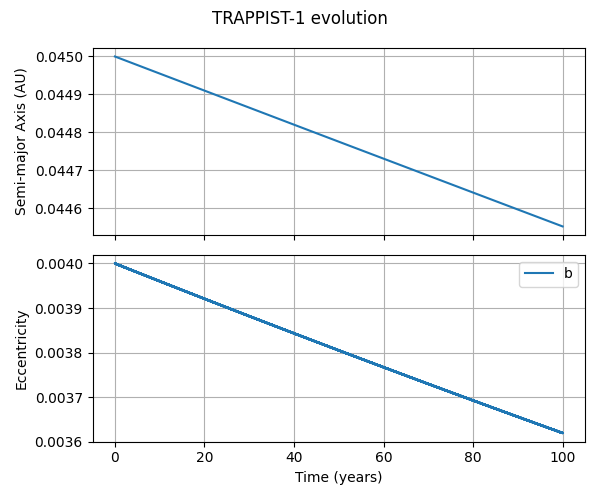

In [13]:
%matplotlib widget

def plot_trappist1():
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig.set_figwidth(6.0)
    fig.set_figheight(5.0)

    for p in range(num_planets):
        # could also try plotting log
        ax1.plot(times, df["a"], label=f'{chr(98+p)}') 
        ax2.plot(times, df["e"], label=f'{chr(98+p)}')
        
    plt.xlabel("Time (years)")
    ax1.set_ylabel("Semi-major Axis (AU)")
    ax2.set_ylabel("Eccentricity")
    
    # ax1.set_ylim(0.005, 0.13)
    # ax2.set_ylim(-0.01, 0.3)
    
    # Plot truncation radius 
    # ax1.axhline(r_c, color='gray', ls='--', alpha=0.7)
    # ax1.axhline(r_c - Delta, color='gray', ls='--', alpha=0.1)
    # ax1.axhline(r_c + Delta + 1/A_a, color='gray', ls='--', alpha=0.1)

    # # Stage indicators
    # for stage in [stage_i_end, stage_ii_end, stage_iii_end]:
    #     ax1.axvline(stage, color='gray', ls='--', alpha=0.7)
    #     ax2.axvline(stage, color='gray', ls='--', alpha=0.7)

    fig.subplots_adjust(hspace=0)

    plt.suptitle("TRAPPIST-1 evolution")
    ax1.grid(True); ax2.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

plot_trappist1()